In [1]:
import os
import uuid
import pandas as pd
import chromadb
from sentence_transformers import SentenceTransformer


In [2]:
PERSIST_PATH = r"C:\Users\sushm\OneDrive\Desktop\llm_engineering-main\startup_forge\chroma_store"

os.makedirs(PERSIST_PATH, exist_ok=True)
print("Persist path exists:", os.path.exists(PERSIST_PATH))


Persist path exists: True


In [3]:
client = chromadb.PersistentClient(path=PERSIST_PATH)

print("✅ PersistentClient created")


✅ PersistentClient created


In [4]:
founder_collection = client.get_or_create_collection(
    name="founders_collection",
    metadata={"hnsw:space": "cosine"}
)

investor_collection = client.get_or_create_collection(
    name="investors_collection",
    metadata={"hnsw:space": "cosine"}
)

print(client.list_collections())


[Collection(id=35e6573e-1bea-47d6-b41c-7b2170232b3f, name=investors_collection), Collection(id=c0be4ae7-32cc-456d-b5a2-317025d87bd3, name=founders_collection)]


In [5]:
founders_df = pd.read_csv("founders_cleaned.csv")
investors_df = pd.read_csv("investors_cleaned.csv")


In [6]:
def clean_metadata(d):
    return {k: v for k, v in d.items() if v is not None and v == v}


In [7]:
def founder_row_to_text(row):
    parts = []
    if pd.notna(row.get("company")):
        parts.append(f"Company: {row['company']}.")
    if pd.notna(row.get("founder_name")):
        parts.append(f"Founder: {row['founder_name']}.")
    if pd.notna(row.get("funding_round")):
        parts.append(f"Funding round: {row['funding_round']}.")
    return " ".join(parts)


In [8]:
def investor_row_to_text(row):
    parts = []
    if pd.notna(row.get("name")):
        parts.append(f"Investor name: {row['name']}.")
    if pd.notna(row.get("firm_name")):
        parts.append(f"Firm: {row['firm_name']}.")
    if pd.notna(row.get("investment_stage_pref")):
        parts.append(f"Preferred stage: {row['investment_stage_pref']}.")
    if pd.notna(row.get("primary_domain")):
        parts.append(f"Domain: {row['primary_domain']}.")
    return " ".join(parts)


In [9]:
founder_docs, founder_meta, founder_ids = [], [], []

for _, row in founders_df.iterrows():
    text = founder_row_to_text(row)
    if not text.strip():
        continue
    founder_docs.append(text)
    founder_meta.append(clean_metadata({"role": "founder"}))
    founder_ids.append(str(uuid.uuid4()))

investor_docs, investor_meta, investor_ids = [], [], []

for _, row in investors_df.iterrows():
    text = investor_row_to_text(row)
    if not text.strip():
        continue
    investor_docs.append(text)
    investor_meta.append(clean_metadata({"role": "investor"}))
    investor_ids.append(str(uuid.uuid4()))

print(len(founder_docs), len(investor_docs))


159 53


In [10]:
model = SentenceTransformer("BAAI/bge-base-en-v1.5")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [11]:
founder_embeddings = model.encode(founder_docs, normalize_embeddings=True)
investor_embeddings = model.encode(investor_docs, normalize_embeddings=True)


In [12]:
founder_collection.add(
    documents=founder_docs,
    embeddings=founder_embeddings.tolist(),
    metadatas=founder_meta,
    ids=founder_ids
)

investor_collection.add(
    documents=investor_docs,
    embeddings=investor_embeddings.tolist(),
    metadatas=investor_meta,
    ids=investor_ids
)

print("✅ Data added")


✅ Data added


In [13]:
print(os.listdir(PERSIST_PATH))


['b05ac97f-f802-45c0-be83-0b69084f3e63', 'b16c7b37-57d2-4f96-b2f1-c8bb394663cf', 'chroma.sqlite3']


In [14]:
print("Founders count:", founder_collection.count())
print("Investors count:", investor_collection.count())


Founders count: 159
Investors count: 53


In [15]:
query_emb = model.encode(
    ["AI startup founder funded in Series A"],
    normalize_embeddings=True
)

res = founder_collection.query(
    query_embeddings=query_emb.tolist(),
    n_results=5
)

for i, doc in enumerate(res["documents"][0]):
    print(f"\nResult {i+1}:")
    print(doc)



Result 1:
Company: Leap AI.

Result 2:
Company: Julius AI.

Result 3:
Company: Roe AI.

Result 4:
Company: Yorby AI.

Result 5:
Company: ego AI.


In [16]:
query_emb = model.encode(
    ["Investor interested in AI startups"],
    normalize_embeddings=True
)

res = investor_collection.query(
    query_embeddings=query_emb.tolist(),
    n_results=5
)

for i, doc in enumerate(res["documents"][0]):
    print(f"\nInvestor {i+1}:")
    print(doc)



Investor 1:
Investor name: Harsh Patel. Firm: Wireframe Ventures. Preferred stage: ['Seed', 'Other Lists', 'Pre-seed']. Domain: Robotics.

Investor 2:
Investor name: Adam Draper. Firm: Boost VC. Preferred stage: ['Seed', 'Other Lists', 'Pre-seed']. Domain: Fashion.

Investor 3:
Investor name: Seth Berman. Firm: Susa Ventures. Preferred stage: ['Seed', 'Other Lists', 'Pre-seed']. Domain: Games.

Investor 4:
Investor name: Josh Kopelman. Firm: First Round Capital. Preferred stage: ['Series B', 'Seed', 'Series A', 'Other Lists', 'Pre-seed']. Domain: AI.

Investor 5:
Investor name: Nat Friedman. Firm: C2 Investment. Preferred stage: ['Series B', 'Series A', 'Seed', 'Other Lists', 'Pre-seed', 'Series C']. Domain: AI.


In [6]:
founder_data = founder_collection.get(
    include=["embeddings", "metadatas", "documents"]
)

X_founders = np.array(founder_data["embeddings"])
investor_data = investor_collection.get(
    include=["embeddings", "metadatas", "documents"]
)

X_investors = np.array(investor_data["embeddings"])


NameError: name 'founder_collection' is not defined

In [20]:
import numpy as np

X_founders = np.array(founder_embeddings)
X_investors = np.array(investor_embeddings)

labels_founders = ["Founder"] * len(X_founders)
labels_investors = ["Investor"] * len(X_investors)

X_all = np.vstack([X_founders, X_investors])
labels_all = labels_founders + labels_investors


In [21]:
import umap
import matplotlib.pyplot as plt

umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_2d = umap_2d.fit_transform(X_all)


C:\Users\sushm\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


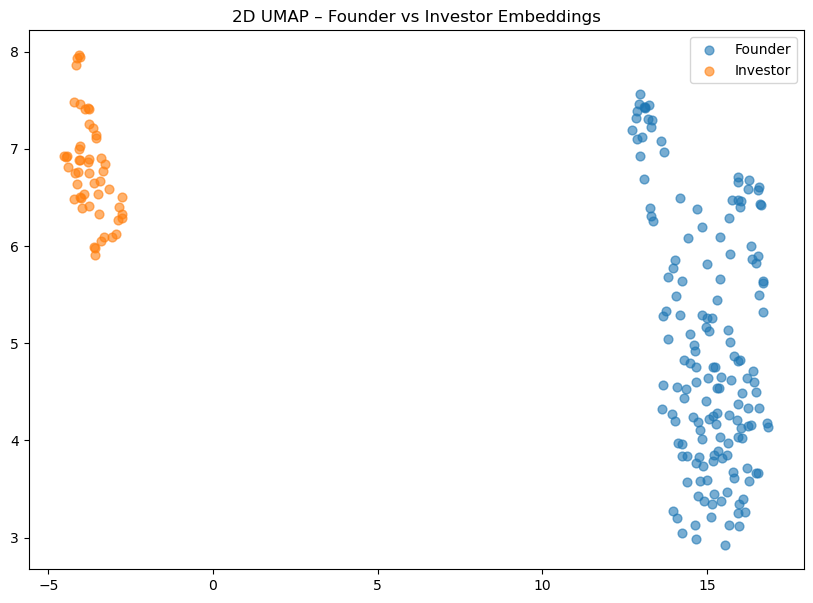

In [22]:
plt.figure(figsize=(10, 7))

for label in set(labels_all):
    idx = [i for i, l in enumerate(labels_all) if l == label]
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        label=label,
        alpha=0.6,
        s=40
    )

plt.legend()
plt.title("2D UMAP – Founder vs Investor Embeddings")
plt.show()


C:\Users\sushm\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



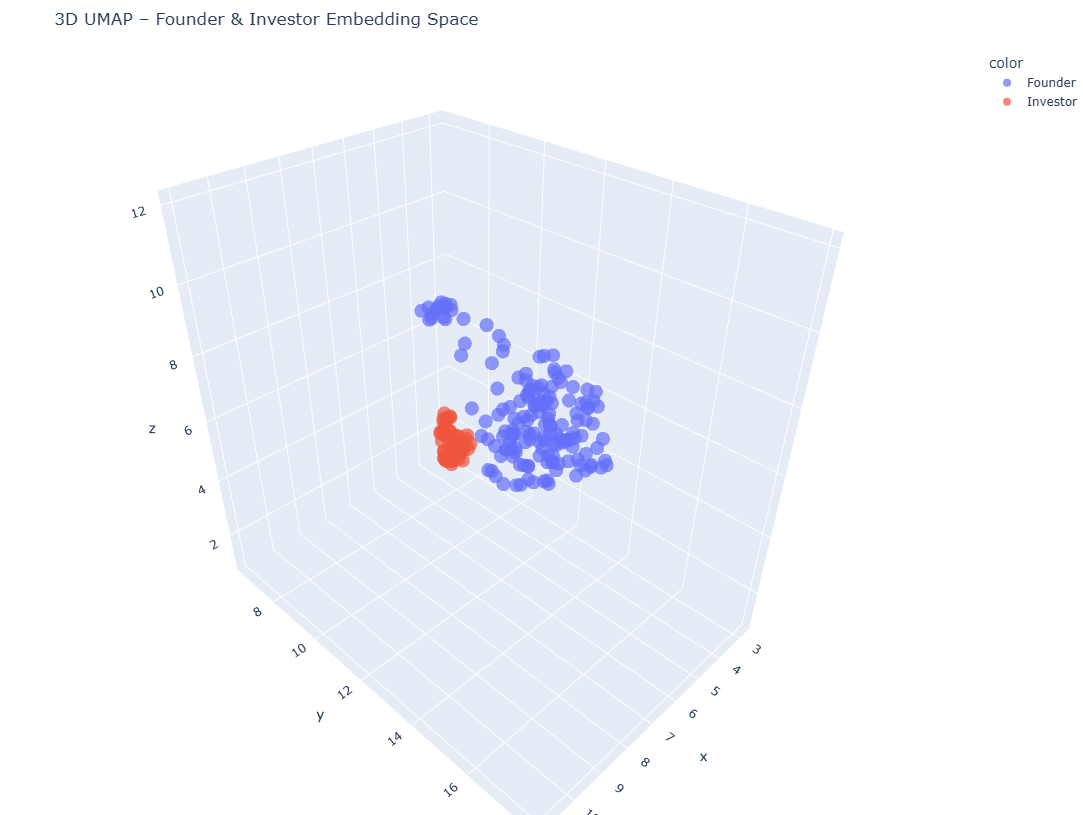

In [28]:
import plotly.express as px

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_3d = umap_3d.fit_transform(X_all)

fig = px.scatter_3d(
    x=X_3d[:, 0],
    y=X_3d[:, 1],
    z=X_3d[:, 2],
    color=labels_all,
    title="3D UMAP – Founder & Investor Embedding Space",
    opacity=0.7
)

fig.update_layout(
    width=1200,   # increase width
    height=800,   # increase height
    margin=dict(l=0, r=0, b=0, t=50)
)



fig.show()


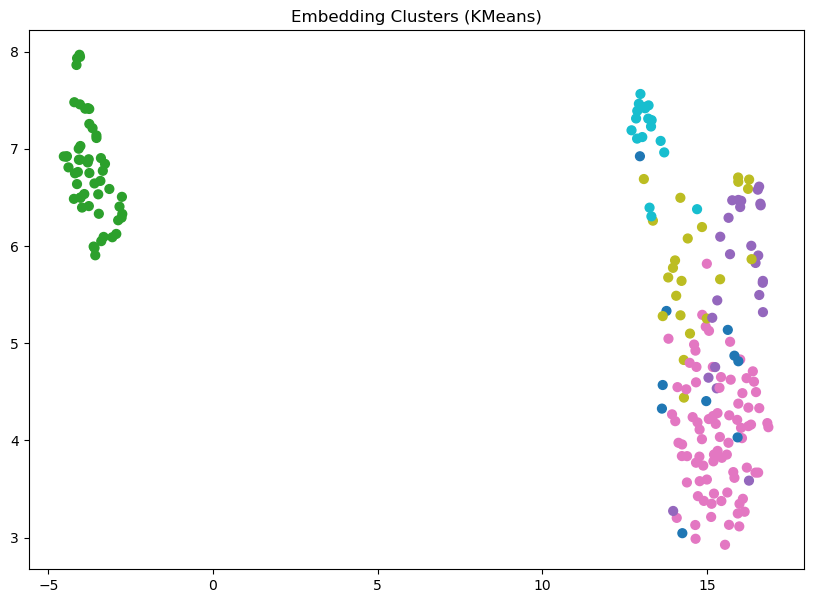

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_all)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap="tab10", s=40)
plt.title("Embedding Clusters (KMeans)")
plt.show()


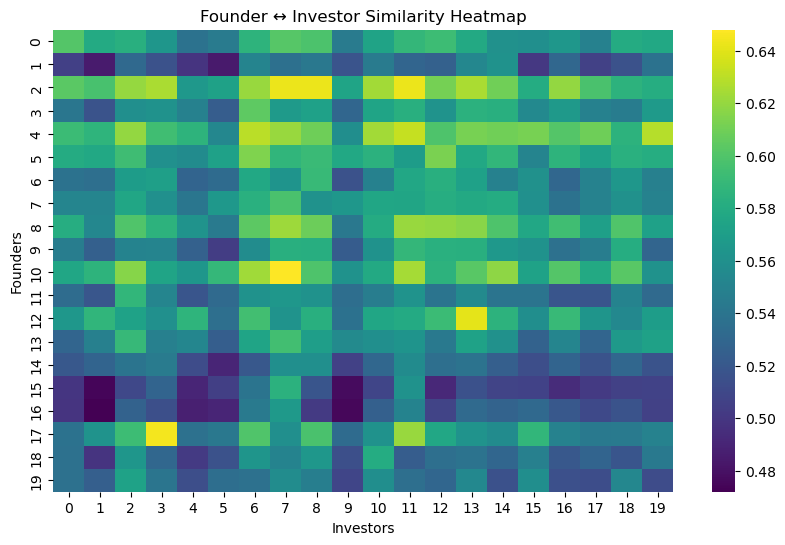

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sim_matrix = cosine_similarity(X_founders[:20], X_investors[:20])

plt.figure(figsize=(10, 6))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Founder ↔ Investor Similarity Heatmap")
plt.xlabel("Investors")
plt.ylabel("Founders")
plt.show()


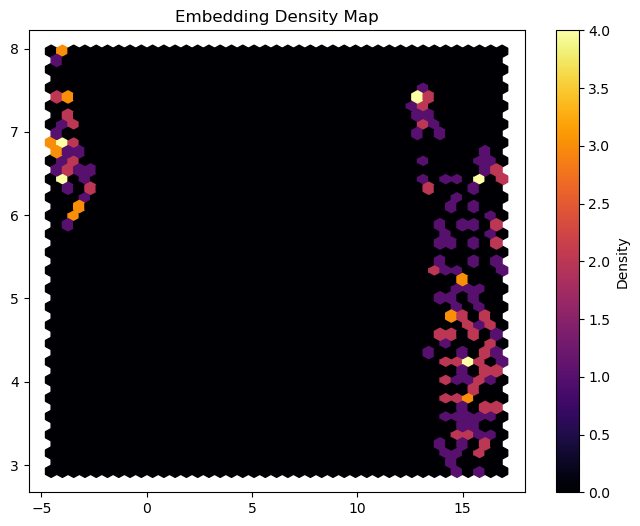

In [26]:
plt.figure(figsize=(8, 6))
plt.hexbin(X_2d[:, 0], X_2d[:, 1], gridsize=40, cmap="inferno")
plt.colorbar(label="Density")
plt.title("Embedding Density Map")
plt.show()


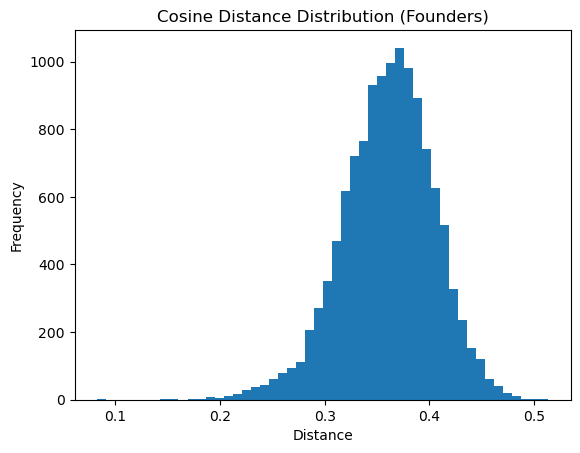

In [27]:
from scipy.spatial.distance import pdist

distances = pdist(X_founders, metric="cosine")

plt.hist(distances, bins=50)
plt.title("Cosine Distance Distribution (Founders)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [29]:
# pull metadata + docs from chroma
founder_data = founder_collection.get(
    include=["metadatas", "documents", "embeddings"]
)

investor_data = investor_collection.get(
    include=["metadatas", "documents", "embeddings"]
)

import numpy as np

X_all = np.vstack([
    np.array(founder_data["embeddings"]),
    np.array(investor_data["embeddings"])
])

labels_all = (
    ["Founder"] * len(founder_data["embeddings"]) +
    ["Investor"] * len(investor_data["embeddings"])
)

hover_text = []

for m, d in zip(founder_data["metadatas"], founder_data["documents"]):
    hover_text.append(
        f"Role: Founder<br>"
        f"Company: {m.get('company', 'NA')}<br>"
        f"Funding: {m.get('funding_round', 'NA')}<br>"
        f"Text: {d[:150]}..."
    )

for m, d in zip(investor_data["metadatas"], investor_data["documents"]):
    hover_text.append(
        f"Role: Investor<br>"
        f"Firm: {m.get('firm_name', 'NA')}<br>"
        f"Stage: {m.get('investment_stage_pref', 'NA')}<br>"
        f"Text: {d[:150]}..."
    )


C:\Users\sushm\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



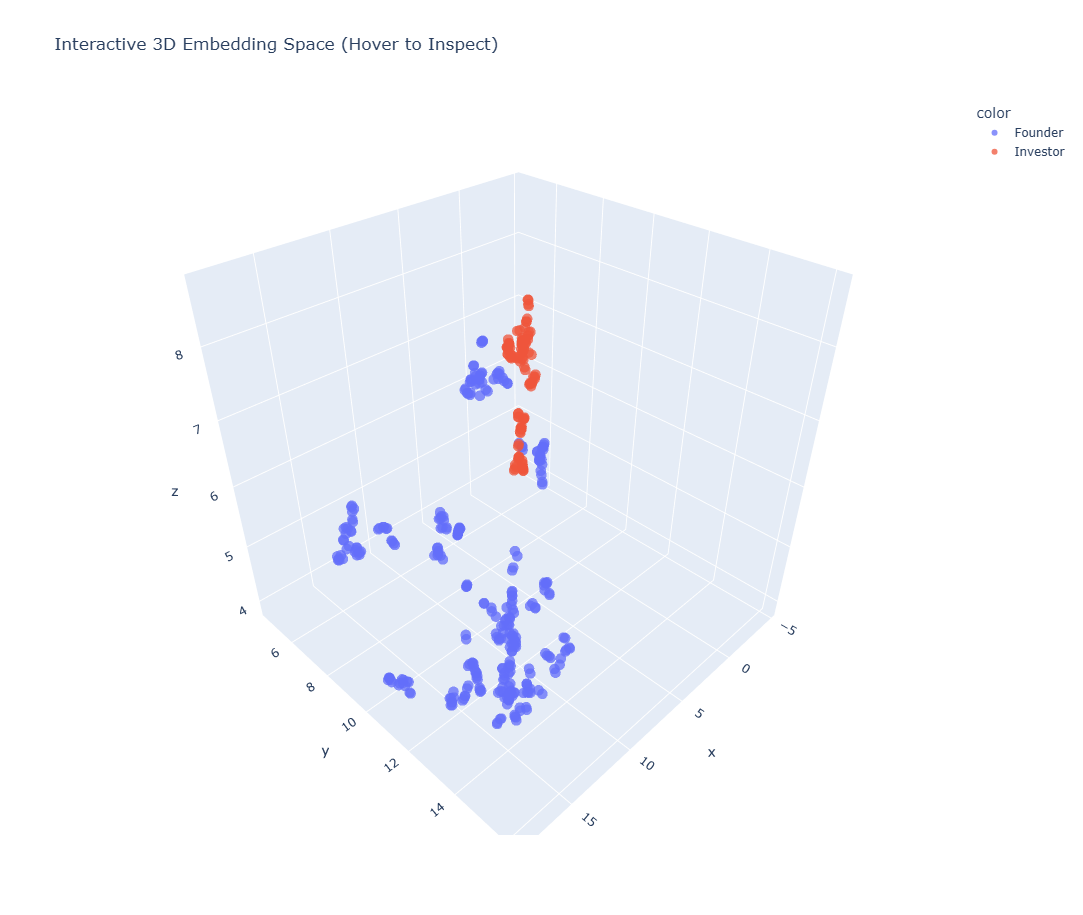

In [32]:
import umap
import plotly.express as px

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_3d = umap_3d.fit_transform(X_all)

fig = px.scatter_3d(
    x=X_3d[:,0],
    y=X_3d[:,1],
    z=X_3d[:,2],
    color=labels_all,
    hover_name=labels_all,
    hover_data={"info": hover_text},
    title="Interactive 3D Embedding Space (Hover to Inspect)",
    opacity=0.75
)

fig.update_layout(
    width=1400,
    height=900,
    
)

fig.update_traces(marker=dict(size=6))
fig.show()


In [33]:
query = "AI startup building healthcare platform"

query_emb = model.encode([query], normalize_embeddings=True)

res = founder_collection.query(
    query_embeddings=query_emb.tolist(),
    n_results=10,
    include=["documents", "embeddings"]
)

query_vec = query_emb[0]
neighbor_vecs = np.array(res["embeddings"][0])


C:\Users\sushm\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\sushm\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



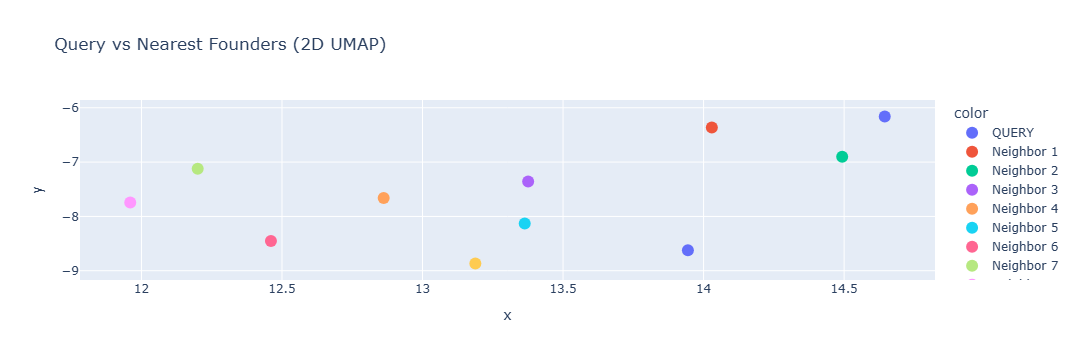

In [34]:
X_query = np.vstack([query_vec, neighbor_vecs])
labels = ["QUERY"] + [f"Neighbor {i+1}" for i in range(len(neighbor_vecs))]

umap_q = umap.UMAP(n_components=2, metric="cosine", random_state=42)
X_q_2d = umap_q.fit_transform(X_query)

fig = px.scatter(
    x=X_q_2d[:,0],
    y=X_q_2d[:,1],
    color=labels,
    title="Query vs Nearest Founders (2D UMAP)"
)

fig.update_traces(marker=dict(size=12))
fig.show()


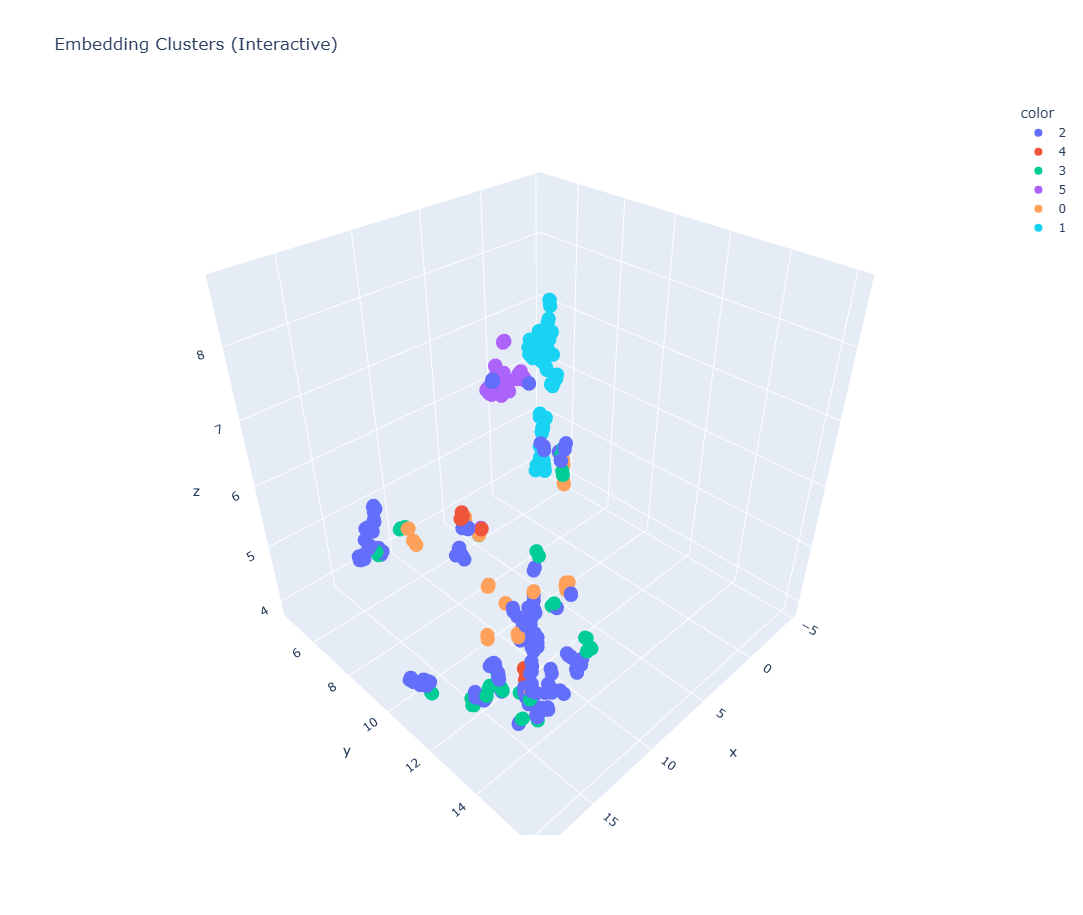

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_all)

fig = px.scatter_3d(
    x=X_3d[:,0],
    y=X_3d[:,1],
    z=X_3d[:,2],
    color=clusters.astype(str),
    hover_data={"info": hover_text},
    title="Embedding Clusters (Interactive)"
)

fig.update_layout(width=1400, height=900)
fig.show()


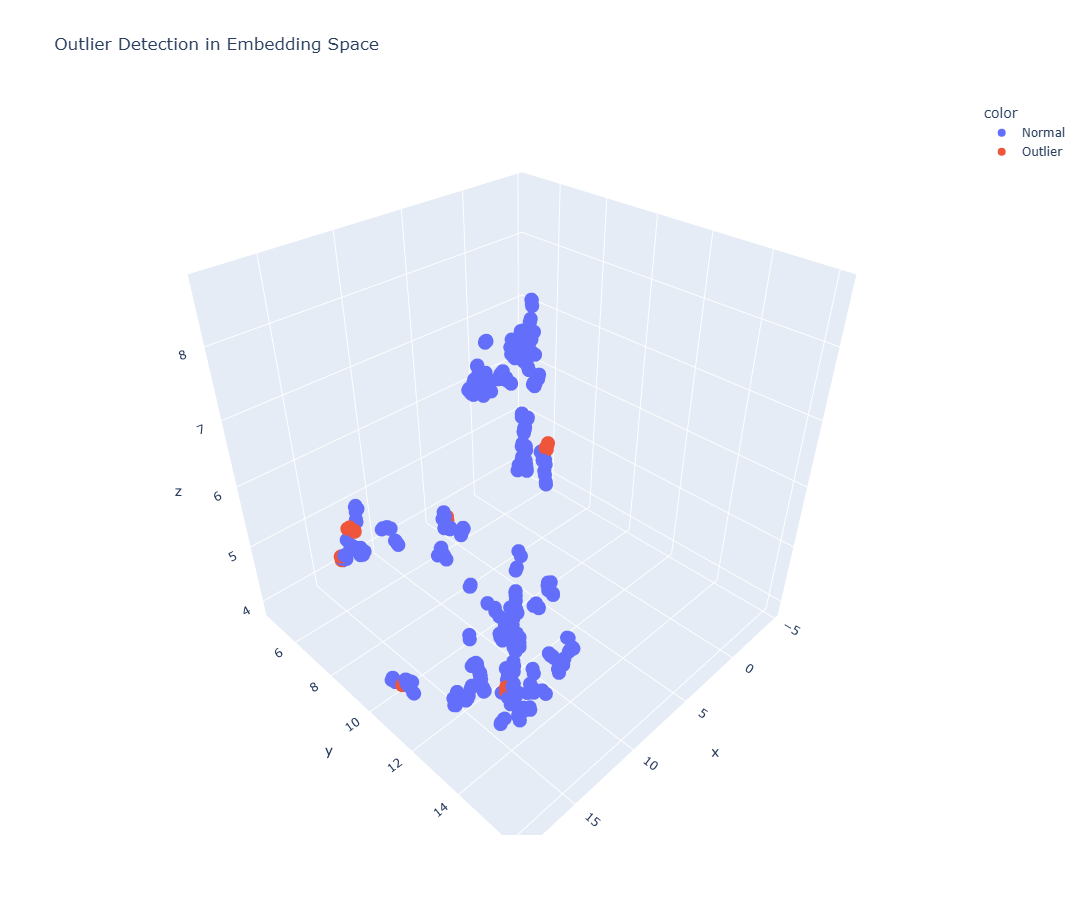

In [37]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_all)

fig = px.scatter_3d(
    x=X_3d[:,0],
    y=X_3d[:,1],
    z=X_3d[:,2],
    color=["Outlier" if o == -1 else "Normal" for o in outliers],
    hover_data={"info": hover_text},
    title="Outlier Detection in Embedding Space"
)
fig.update_layout(width=1400, height=900)
fig.show()
